In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [2]:
# Inspect the data
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [3]:
# Inspect the data
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


# Data cleaning

### Handling Missing Values and '?'

In [4]:
import numpy as np
# Replace "?" with NaN in the specified columns using .loc
X.loc[X['workclass'] == "?", 'workclass'] = np.nan
X.loc[X['occupation'] == "?", 'occupation'] = np.nan
X.loc[X['native-country'] == "?", 'native-country'] = np.nan

# Impute missing values with the most frequent value (mode) using .loc[]
X.loc[:, 'workclass'] = X['workclass'].fillna(X['workclass'].mode()[0])
X.loc[:, 'occupation'] = X['occupation'].fillna(X['occupation'].mode()[0])
X.loc[:, 'native-country'] = X['native-country'].fillna(X['native-country'].mode()[0])

In [5]:
# Standardize original categorical columns
X.loc[:, 'native-country'] = X['native-country'].str.lower()

In [6]:
# Check for missing values in the features
X.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

### One-hot Encoding

In [7]:
# Perform one-hot encoding for categorical features
X = pd.get_dummies(X, columns=['workclass', 'education', 'marital-status', 'occupation',
                                          'relationship', 'race', 'sex', 'native-country'], drop_first=True)

### Ensuring Correct Data Types

In [8]:
X.loc[:, 'age'] = X['age'].astype(int)
X.loc[:, 'fnlwgt'] = X['fnlwgt'].astype(int)
X.loc[:, 'capital-gain'] = X['capital-gain'].astype(int)
X.loc[:, 'capital-loss'] = X['capital-loss'].astype(int)
X.loc[:, 'hours-per-week'] = X['hours-per-week'].astype(int)


In [9]:
# Check the data types of the columns
X.dtypes

age                               int64
fnlwgt                            int64
education-num                     int64
capital-gain                      int64
capital-loss                      int64
                                  ...  
native-country_thailand            bool
native-country_trinadad&tobago     bool
native-country_united-states       bool
native-country_vietnam             bool
native-country_yugoslavia          bool
Length: 97, dtype: object

### Feature Engineering

In [10]:
# Create a new feature 'net-capital-gain'
X['net-capital-gain'] = X['capital-gain'] - X['capital-loss']

# Drop the original 'capital-gain' and 'capital-loss' columns if no longer needed
X.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)

In [11]:
# Drop `education-num` since it seems redundant
X.drop('education-num', axis=1, inplace=True)

In [12]:
X.head(10)

,age,fnlwgt,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,native-country_puerto-rico,native-country_scotland,native-country_south,native-country_taiwan,native-country_thailand,native-country_trinadad&tobago,native-country_united-states,native-country_vietnam,native-country_yugoslavia,net-capital-gain
0,39,77516,40,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,2174
1,50,83311,13,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,0
2,38,215646,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
3,53,234721,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
4,28,338409,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
5,37,284582,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
6,49,160187,16,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
7,52,209642,45,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,0
8,31,45781,50,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,14084
9,42,159449,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,5178


In [13]:
print(X.shape)
print(y.shape)

(48842, 95)
(48842, 1)


In [14]:
#join df

merged_df = X.join(y)
merged_df.head(10)

,age,fnlwgt,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,native-country_scotland,native-country_south,native-country_taiwan,native-country_thailand,native-country_trinadad&tobago,native-country_united-states,native-country_vietnam,native-country_yugoslavia,net-capital-gain,income
0,39,77516,40,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,2174,<=50K
1,50,83311,13,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,0,<=50K
2,38,215646,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0,<=50K
3,53,234721,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0,<=50K
4,28,338409,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,0,<=50K
5,37,284582,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0,<=50K
6,49,160187,16,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,0,<=50K
7,52,209642,45,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,0,>50K
8,31,45781,50,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,14084,>50K
9,42,159449,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,5178,>50K


In [15]:
merged_df['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [16]:
merged_df['income'] = merged_df['income'].astype('string')

In [17]:
# Clean the 'Income' column to remove the period
merged_df['income'] = merged_df['income'].str.replace('.', '', regex=False)

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
print(merged_df)

Cleaned DataFrame:
       age  fnlwgt  hours-per-week  workclass_Local-gov  \
0       39   77516              40                False   
1       50   83311              13                False   
2       38  215646              40                False   
3       53  234721              40                False   
4       28  338409              40                False   
...    ...     ...             ...                  ...   
48837   39  215419              36                False   
48838   64  321403              40                False   
48839   38  374983              50                False   
48840   44   83891              40                False   
48841   35  182148              60                False   

       workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
0                       False              False                   False   
1                       False              False                   False   
2                       False               

In [18]:
merged_df['income'].unique()

<StringArray>
['<=50K', '>50K']
Length: 2, dtype: string

In [19]:
# Alternatively, you can use map:
merged_df['income'] = merged_df['income'].map({'<=50K': 0, '>50K': 1})

# Check the DataFrame after conversion
print("DataFrame after conversion:")
merged_df.head(10)

DataFrame after conversion:


,age,fnlwgt,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,native-country_scotland,native-country_south,native-country_taiwan,native-country_thailand,native-country_trinadad&tobago,native-country_united-states,native-country_vietnam,native-country_yugoslavia,net-capital-gain,income
0,39,77516,40,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,2174,0
1,50,83311,13,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,0,0
2,38,215646,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0,0
3,53,234721,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0,0
4,28,338409,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
5,37,284582,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0,0
6,49,160187,16,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
7,52,209642,45,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,0,1
8,31,45781,50,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,14084,1
9,42,159449,40,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,5178,1


In [20]:
print(merged_df.columns)

Index(['age', 'fnlwgt', 'hours-per-week', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Mach

In [21]:
full_encoded_df = merged_df.copy()

In [22]:
# Select relevant features for clustering
features = full_encoded_df[['age', 'hours-per-week', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
       'sex_Male','income']]

# K-Means Clustering

In [23]:
#Step 4: Scale Your Data Standardize your features to ensure they are on the same scale.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


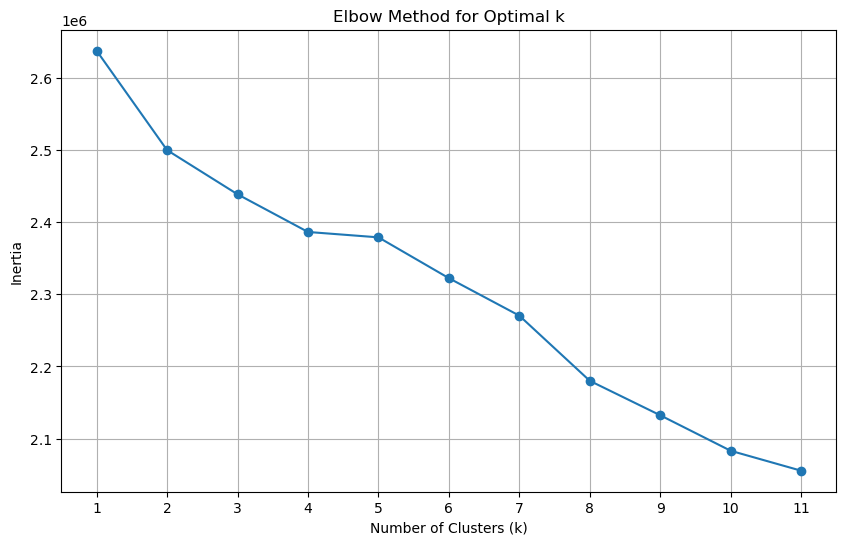

In [24]:
#Step 5: Determine the Optimal Number of Clusters. Use the elbow method to find the optimal number of clusters.

inertia = []
k_values = range(1, 12)  # Testing k from 1 to 11
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

In [25]:
# Step 4: Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [31]:
# Step 5: Fit K-means model on PCA-transformed data
optimal_k = 4  # Replace this with the value you find optimal from the Elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features_pca)

KMeans(n_clusters=4, random_state=42)

In [32]:
# Step 6: Add Cluster Labels to the original DataFrame
full_encoded_df['Cluster'] = kmeans.labels_

In [33]:
# Step 7: Analyze the Clusters
cluster_analysis = full_encoded_df.groupby('Cluster').mean()
print(cluster_analysis)

               age         fnlwgt  hours-per-week  workclass_Local-gov  \
Cluster                                                                  
0        25.542553  195276.316984       35.413858             0.004142   
1        43.819182  184627.887671       44.447466             0.056003   
2        36.506523  194649.116468       38.173473             0.039894   
3        46.926720  189092.526753       38.752576             0.242439   

         workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
Cluster                                                                      
0                      0.000471           0.961872                0.005555   
1                      0.000000           0.675684                0.066269   
2                      0.000378           0.862356                0.004727   
3                      0.000166           0.457793                0.025424   

         workclass_Self-emp-not-inc  workclass_State-gov  \
Cluster                   

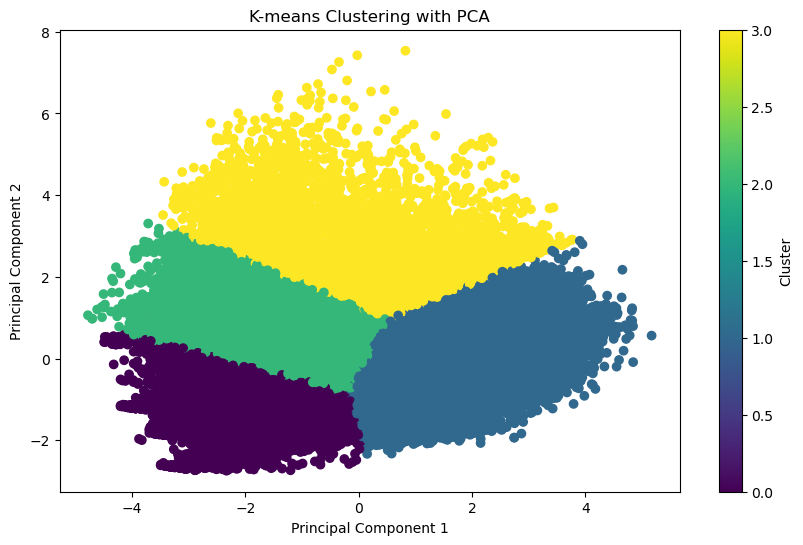

In [34]:
# Optional: Visualize the clusters using the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [35]:
# Step 8: Visualize the clusters using hvPlot
# Create a DataFrame for PCA results and cluster labels
pca_df = pd.DataFrame(features_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Plot using hvPlot
scatter_plot = pca_df.hvplot.scatter(
    x='PC1',
    y='PC2',
    by='Cluster',
    title='K-means Clustering with PCA',
    xlabel='Principal Component 1',
    ylabel='Principal Component 2',
    width=800,
    height=600,
    hover_cols=['Cluster']
)

scatter_plot

:NdOverlay   [Cluster]
   :Scatter   [PC1]   (PC2,Cluster)